# Modular GLASSO
This is a companion notebook to the paper entitled "Module-based regularization improves Gaussian graphical models when observing noisy data".


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import infomap
import matplotlib.pyplot as plt
from scipy.stats import wishart
from sklearn.metrics import adjusted_mutual_info_score
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [2]:
# run the R implementation of the graphical lasso
glasso = importr('glasso')
cvglasso = importr('CVglasso')

# R functions
robjects.r(
    '''
f_glasso <- function(x, rho, nS) {
    s<- var(x)
    a<-glasso(s, rho, nS)
    a
}
'''
)
glassoR = robjects.r['f_glasso']

robjects.r(
    '''
f_CVglasso <- function(x) {
    a<-CVglasso(x)
    a
}
'''
)
CVglassoR = robjects.r['f_CVglasso']

In [3]:
def wishartSample(num_blocks, block_size, covariance, deg_f, num_samples):
    # block diagonal matrix to use as covariance matrix
    sub_block = np.full((block_size, block_size), covariance)
    np.fill_diagonal(sub_block, 1)
    block_diag_matrix = np.block([[sub_block if i==j else np.zeros((block_size, block_size)) for j in range(num_blocks)] for i in range(num_blocks)])
    # sample a noisy covariance matrix from the wishart distribution
    block_diag_matrix_wishart = wishart.rvs(deg_f, block_diag_matrix, 1)
    # sample from multivariate normal using the noisy covariance matrix
    mean = np.zeros((num_blocks*block_size,))
    sample = np.random.multivariate_normal(mean, block_diag_matrix_wishart/deg_f, size = num_samples)
    sample_df = pd.DataFrame(data=sample)
    return sample_df, block_diag_matrix, block_diag_matrix_wishart

In [4]:
def modularGLASSO(X, lambda_values):
    # crossvalidate the regularization parameter lambda to find the best balance between over and underfitting modular structure to data
    train_codelength_savings = []
    test_codelength_savings  = []
    codelength_savings_best  = 0
    sample_df = pd.DataFrame(data=X)
    for lda in lambda_values:
        # 2-fold splitting of samples
        train_df = sample_df.sample(frac=0.5, axis = 0)
        test_df=sample_df.drop(train_df.index)
        sample_train = train_df.to_numpy(copy=True)
        sample_test = test_df.to_numpy(copy=True)
        sample_train -= sample_train.mean(axis=0)
        sample_train /= sample_train.std(axis=0)
        num_samples_train = len(train_df.index)
        # run the R GLASSO package
        numpy2ri.activate()
        glasso_res = glassoR(sample_train, lda, num_samples_train)
        numpy2ri.deactivate()
        precision_train = np.array(glasso_res[1]) # precision matrix in [1]
        # calculate the partial correlation matrix
        partial_corr_train = -precision_train / np.sqrt(np.outer(np.diag(precision_train), np.diag(precision_train)))
        # make training network and run Infomap
        np.fill_diagonal(partial_corr_train, 0) # avoid self links
        G_train = nx.from_numpy_matrix(partial_corr_train)
        infomap_train = infomap.Infomap(silent = True, two_level = True)
        infomap_train.add_networkx_graph(G_train)
        infomap_train.run()
        train_codelength_savings.append(infomap_train.relative_codelength_savings)
        # make test network and run Infomap with the modules from the training network
        sample_test -= sample_test.mean(axis=0)
        sample_test /= sample_test.std(axis=0)
        num_samples_test = len(test_df.index)
        numpy2ri.activate()
        glasso_res = glassoR(sample_test, lda, num_samples_test)
        numpy2ri.deactivate()
        precision_test = np.array(glasso_res[1]) # precision matrix in [1]
        partial_corr_test = -precision_test / np.sqrt(np.outer(np.diag(precision_test), np.diag(precision_test)))
        np.fill_diagonal(partial_corr_test, 0) # avoid self links
        G_test = nx.from_numpy_matrix(partial_corr_test)
        infomap_test = infomap.Infomap(silent = True, two_level = True, no_infomap = True)
        infomap_test.add_networkx_graph(G_test)
        infomap_test.run(initial_partition = dict(infomap_train.modules))
        test_codelength_savings.append(infomap_test.relative_codelength_savings)
    return train_codelength_savings, test_codelength_savings 

In [5]:
# sample data
num_blocks, block_size, covariance, num_samples = 10, 10, 0.4, 100
deg_f = num_blocks*block_size
sample_df, block_diag_matrix, block_diag_matrix_wishart = wishartSample(num_blocks, block_size, covariance, deg_f, num_samples)
# save the planted partition for later comparison
plantedPartition = []
for i in range(1,num_blocks+1):
    plantedPartition += np.full(block_size, i).tolist()

(Text(0.5, 0, 'Feature'),
 Text(0, 0.5, 'Sample'),
 Text(0.5, 1.0, 'Sampled data'))

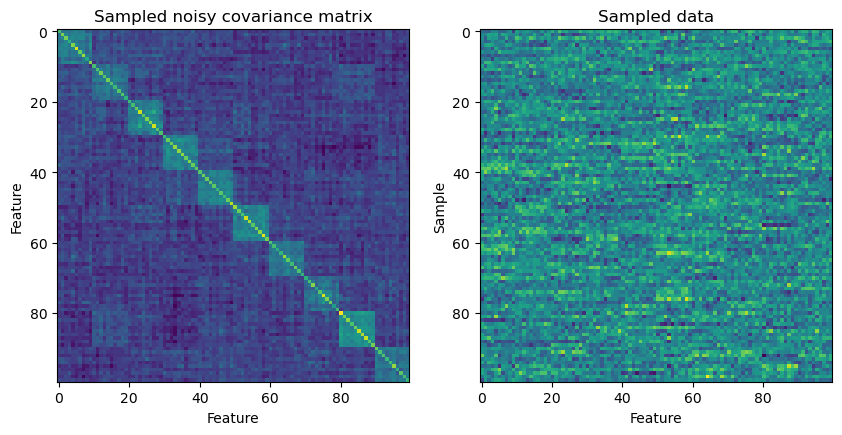

In [6]:
# plot the sampled data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize=(10,5))
ax1.imshow(block_diag_matrix_wishart)
ax2.imshow(sample_df)
ax1.set_xlabel('Feature'), ax1.set_ylabel('Feature'), ax1.set_title('Sampled noisy covariance matrix')
ax2.set_xlabel('Feature'), ax2.set_ylabel('Sample'), ax2.set_title('Sampled data')

Text(0.5, 1.0, 'Network corresponding to lambda = 0.4, \n with AMI = 0.8328098098928115')

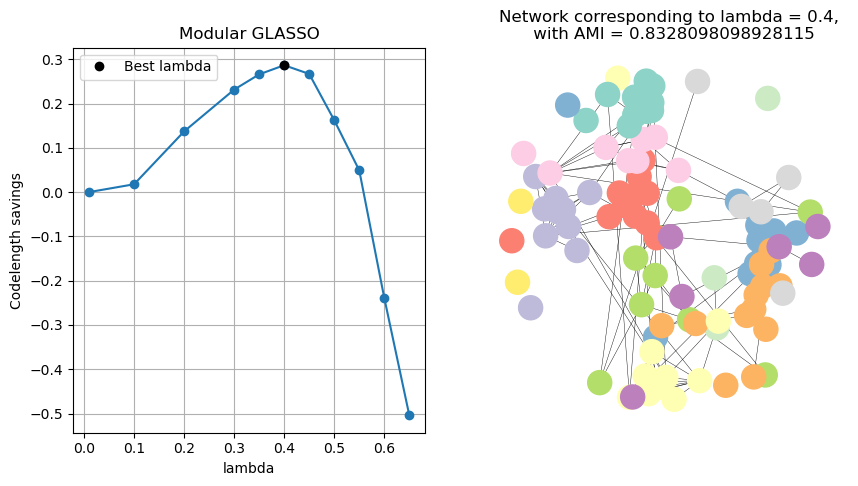

In [7]:
# run modularGLASSO several times and average
# plot the code length savings at each evaluated lambda value
# find the best lambda where the test code length savings peak
lambda_values = [0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
nRuns = 10
train_codelength_savings, test_codelength_savings = np.zeros((1, len(lambda_values))), np.zeros((1, len(lambda_values)))
for _ in range(0, nRuns):
    train_codelength_savings_, test_codelength_savings_ = modularGLASSO(sample_df.values, lambda_values)
    train_codelength_savings+=train_codelength_savings_
    test_codelength_savings+=test_codelength_savings_
lambda_best = lambda_values[test_codelength_savings.argmax()]
# plot the network obtained using the optimal lambda
numpy2ri.activate()
glasso_res = glassoR(sample_df.values, lambda_best, num_samples)
numpy2ri.deactivate()
precision_matrix = np.array(glasso_res[1])
# calculate the partial correlation matrix
partial_corr = -precision_matrix / np.sqrt(np.outer(np.diag(precision_matrix), np.diag(precision_matrix)))
np.fill_diagonal(partial_corr, 0) # avoid self links
G_modular_glasso = nx.from_numpy_matrix(partial_corr)
im = infomap.Infomap(silent = True, two_level = True)
im.add_networkx_graph(G_modular_glasso)
im.run()
nodelist = G_modular_glasso.nodes
modules = dict(im.modules)
num_modules = im.num_top_modules
AMI = adjusted_mutual_info_score(list(modules.values()), plantedPartition)
pos = nx.spring_layout(G_modular_glasso)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.plot(lambda_values, test_codelength_savings[0]/nRuns, '-o')
ax1.plot(lambda_best, test_codelength_savings.max()/nRuns, 'ko', label='Best lambda')
ax1.grid(), ax1.legend(), ax1.set_xlabel('lambda'), ax1.set_ylabel('Codelength savings');
ax1.set_title('Modular GLASSO')
nx.draw(G_modular_glasso, pos = pos, ax = ax2, node_color = [sns.color_palette('Set3', n_colors=num_modules)[modules[node]-1] for node in nodelist], width = 0.3)
ax2.set_title(f'Network corresponding to lambda = {lambda_best}, \n with AMI = {AMI}')

  |======================================================================| 100%

Text(0.5, 1.0, 'Network corresponding to lambda = 0.0503, \n with AMI = 0.0')

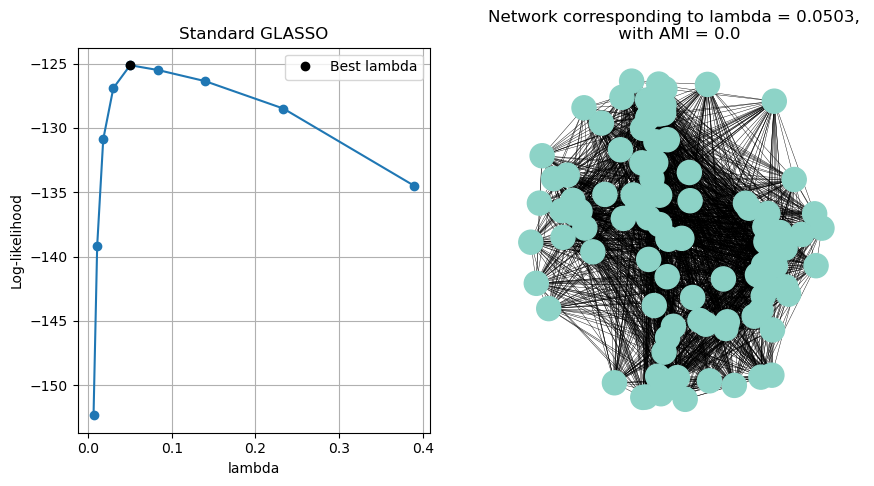

In [8]:
# run Standard GLASSO
X = sample_df.values
X -= X.mean(axis=0)
X /= X.std(axis=0)
numpy2ri.activate()
cvglasso_res = CVglassoR(X)
numpy2ri.deactivate()
lambda_values = np.array(cvglasso_res.rx('Lambdas'))[0][0:-1] # skip largest lambda for clearer plot
log_likelihood = [-num_blocks*block_size/2*np.log(2*np.pi) - 1/(num_blocks*block_size)*x for x in np.array(cvglasso_res.rx('AVG.error'))[0][0:-1]] # AVG.error is scaled and offset from the log-likelihood in CVglasso
lambda_best = lambda_values[np.argmax(log_likelihood)]
# plot the network obtained using the optimal lambda
numpy2ri.activate()
glasso_res = glassoR(sample_df.values, lambda_best, num_samples)
numpy2ri.deactivate()
precision_matrix = np.array(glasso_res[1])
# calculate the partial correlation matrix
partial_corr = -precision_matrix / np.sqrt(np.outer(np.diag(precision_matrix), np.diag(precision_matrix)))
np.fill_diagonal(partial_corr, 0) # avoid self links
G_std_glasso = nx.from_numpy_matrix(partial_corr)
im = infomap.Infomap(silent = True, two_level = True)
im.add_networkx_graph(G_std_glasso)
im.run()
nodelist = G_std_glasso.nodes
modules = dict(im.modules)
num_modules = im.num_top_modules
AMI = adjusted_mutual_info_score(list(modules.values()), plantedPartition)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.plot(lambda_values, log_likelihood, '-o')
ax1.plot(lambda_best, max(log_likelihood), 'ko', label='Best lambda')
ax1.grid(), ax1.legend(), ax1.set_xlabel('lambda'), ax1.set_ylabel('Log-likelihood');
ax1.set_title('Standard GLASSO')
nx.draw(G_std_glasso, pos = pos, ax = ax2, node_color = [sns.color_palette('Set3', n_colors=num_modules)[modules[node]-1] for node in nodelist], width = 0.3)
ax2.set_title(f'Network corresponding to lambda = {lambda_best:.4f}, \n with AMI = {AMI}')